# Tutorial: Microbial Diversity

Flow cytometry can characterize a complex mixture of cells based on their morphology and staining -- and those mixtures are not just mammalian cells! Microbial ecology studies are increasingly turning to flow cytometry, and *Cytoflow* has a bunch of tools that can support these studies too.

This tutorial demonstrates one approach using data from **Görnt A et al, Chemical and microbial similarities and heterogeneities of wastewater from single-household cesspits for decentralised water reuse. Water Reuse 15(2), 255-270. 2025.** <https://doi.org/10.2166/wrd.2025.011>. The authors collected wastewater from cesspits, staines samples with Hoescht dye and propidium iodide, then ran them through a flow cytometer. To compute a Shannon diversity index, they clustered events using a self-organizing map, then treated each cluster as a "species".

If you’d like to follow along, you can do so by downloading one of the **cytoflow-#####-examples-basic.zip** files from the Cytoflow releases page on GitHub. These data are in the **data/microbial_diversity** subfolder. Note that this example uses a function from `scikit-bio` to compute a Shannon diversity index, so you'll need to install that too.

## Preprocessing

The raw data, downloaded from <https://zenodo.org/records/14731601>, contained approximately 600,000 events across *59* channels -- this is what happens when you collect your data on a sorter, I suppose. I subsampled this data to 30,000 events per sample and only included the `FSC`, `SSC`, `PI` (propidium iodide) and `Hoescht` (Hoescht 33342) channels. Additionally, while the study included 20 sites, I have only included data for 5. No other data cleaning or transformation was applied.

## Set up Cytoflow and import the data

In [1]:
import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

Because we don't have any metadata besides the filename, use that as `Sample` metadata.

In [2]:
ex = flow.ImportOp(tubes = [flow.Tube(file = "data/microbial_diversity/Sample_1.fcs",
                                      conditions = {"Sample" : 1}),
                            flow.Tube(file = "data/microbial_diversity/Sample_2.fcs",
                                      conditions = {"Sample" : 2}),
                            flow.Tube(file = "data/microbial_diversity/Sample_3.fcs",
                                      conditions = {"Sample" : 3}),
                            flow.Tube(file = "data/microbial_diversity/Sample_4.fcs",
                                      conditions = {"Sample" : 4}),
                            flow.Tube(file = "data/microbial_diversity/Sample_5.fcs",
                                      conditions = {"Sample" : 5})],
                   conditions = {"Sample" : "int"}).apply()

## Preview and filter data

Let's have a quick look at the FSC/SSC distribution.

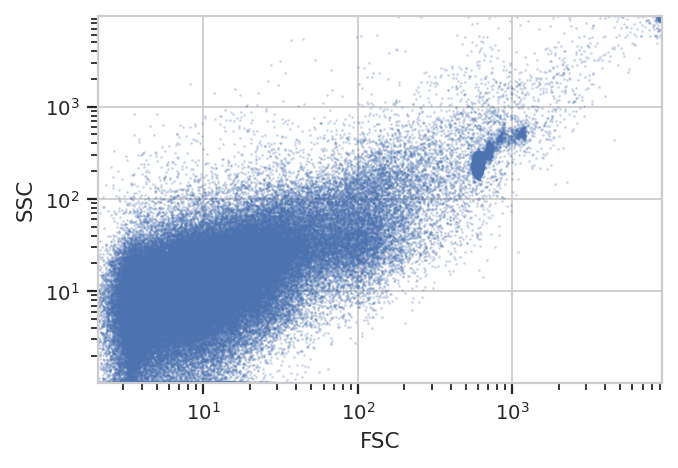

In [7]:
flow.ScatterplotView(xchannel = "FSC",
                     xscale = "log",
                     ychannel = "SSC",
                     yscale = "log").plot(ex, s = 0.2)

Note a number of "strange" clusters, one at about 10^3 in the FSC channel and the other at the very top-right. The investigators included *both* 10 um counting beads *and* 1 um Bright Blue beads; I *think* the counting beads are the clusters at 10^3 and the 10 uM beads are up at 10^4. Both also show up in the `Hoescht` channel:

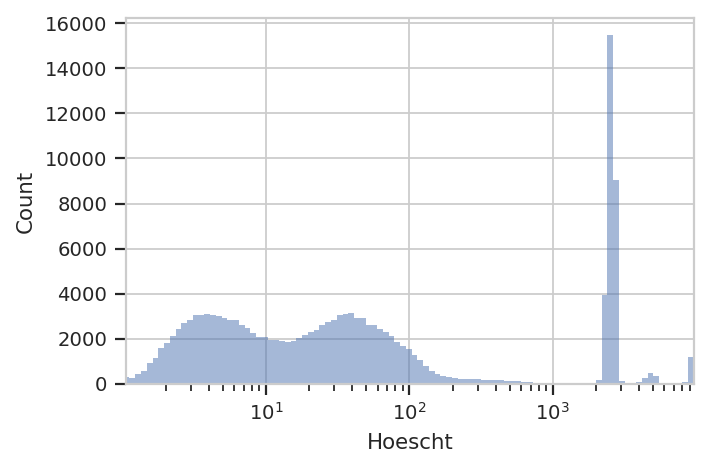

In [8]:
flow.HistogramView(channel = "Hoescht",
                   scale = "log").plot(ex)

The investigators are using Hoescht 33342 dye to distinguish real cells from junk with a threshold of 10 in the `Hoescht` channel. We'll do the same -- that seems to split the low population from the high. But instead of a `ThresholdOp`, let's use a `RangeOp` so we can get rid of the beads, which are all brighter than 10^3.

In [11]:
ex_live = flow.RangeOp(name = "Live",
                       channel = "Hoescht",
                       low = 10,
                       high = 1000).apply(ex)

Let's check: If we plot the `Live == True` subset, did we get rid of those clusters in FSC/SSC?

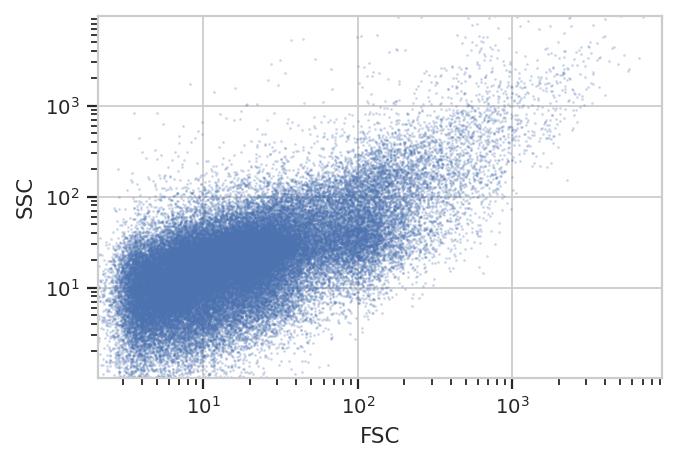

In [14]:
flow.ScatterplotView(xchannel = "FSC",
                     xscale = "log",
                     ychannel = "SSC",
                     yscale = "log",
                     subset = "Live == True").plot(ex_live, s = 0.2)

We sure did -- and without gating out the other events with high FSC and SSC! Nice.

## Cluster with a self-organizing map

The researchers used a self-organizing map with 2025 clusters -- that corresponds to a 45x45 map. They did *not* cluster on `Hoescht`, but instead used only `FSC`, `SSC` and `PI`. (Note that we're disabling consensus clustering -- we want to keep all 2025 clusters. And don't forget to estimate the map using *only* the `Live == True` subset!)

In [23]:
som_op = flow.SOMOp(name = "SOM",
                    channels = ["FSC", "SSC", "PI"],
                    scale = {"FSC" : "log",
                             "SSC" : "log",
                             "PI" : "log"},
                    consensus_cluster = False,
                    width = 45,
                    height = 45)
som_op.estimate(ex_live, subset = "Live == True")

/home/brian/src/cytoflow/cytoflow/utility/minisom.py:645: RuntimeWarning: invalid value encountered in sqrt


As usual, we check `SOMOp.default_view()` to see how the training went:

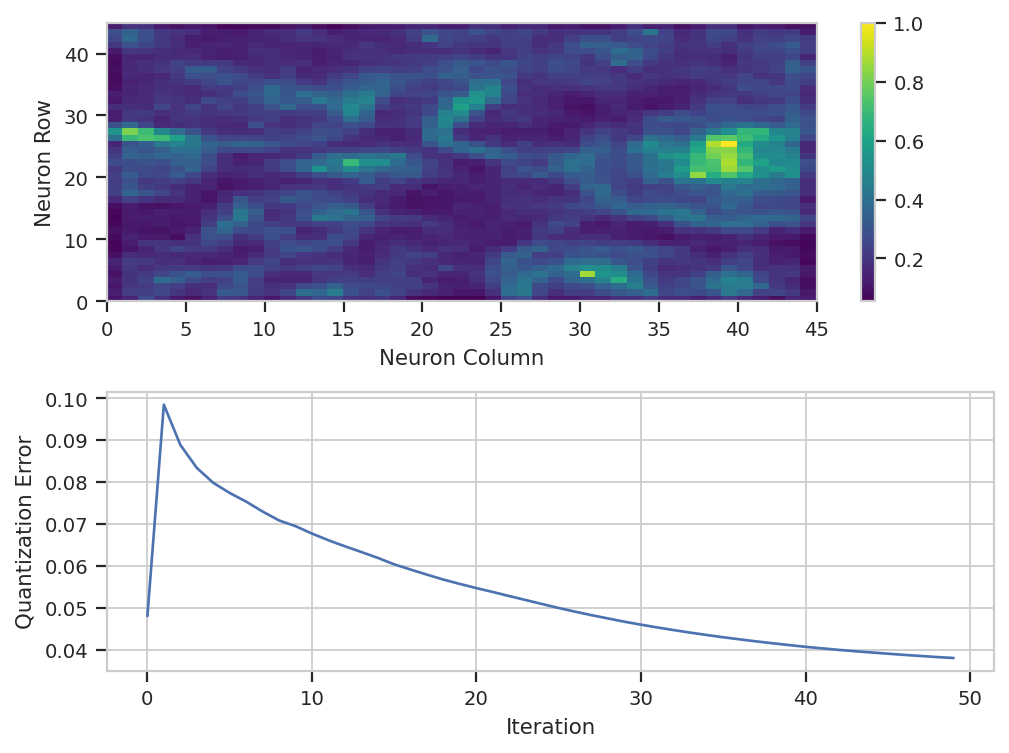

In [24]:
som_op.default_view().plot(ex_live)

Huh. It's not clear that after the default 50 iterations, that the model has converged -- if you'd like, feel free to run the training for more iterations. There is a *lot* of structure in the neuron map, though. And remember, the map was trained using a subset of the data -- by default, 5%. We have to `apply()` it to the entire data set to classify each event.

In [26]:
ex_som = som_op.apply(ex_live)

## Count events in each cluster and compute the Shannon diversity index

Remember, when we want to summarize some flow data, we create a *statistic*. There are a number of operations that do so, but since we're only interested in one channel, we'll use `ChannelStatisticOp`. And actually, since all we're doing is counting events, we can apply the `len` function to any channel we'd like. So let's count the number of events in each cluster in each sample.

In [31]:
ex_count = flow.ChannelStatisticOp(name = "Count",
                                   channel = "FSC",
                                   function = len,
                                   by = ["SOM", "Sample"],
                                   subset = "Live == True").apply(ex_som)

In [32]:
ex_count.statistics['Count']

FSC
SOM  Sample      
0    1       28.0
     2        4.0
     3       13.0
     4        4.0
     5        1.0
...           ...
2024 1       17.0
     2        6.0
     3       10.0
     4       10.0
     5       36.0

[9773 rows x 1 columns]

Great. We have a statistic with two indices, `SOM` (which cluster) and `Sample` (which sample). Let's use `TransformStatisticOp` and the `diversity.alpha.shannon` function from `scikit-bio` to compute the diversity index of each sample. And this is the power of doing flow analysis in Python (and not a GUI) -- you can use *any function in the scientific Python ecosystem* that takes a `pandas.Series` and returns a `float` or a `pandas.Series`. You can complete every step up to this far in the GUI, but this next one can *only* be done in a script or a Jupyter notebook -- otherwise, you'd have to export the previous table and use another tool.

In [34]:
import skbio

ex_diversity = flow.TransformStatisticOp(name = "Diversity",
                                         statistic = "Count",
                                         feature = "FSC",
                                         by = ["Sample"],
                                         function = skbio.diversity.alpha.shannon).apply(ex_count)
ex_diversity.statistics['Diversity']

,FSC
Sample,
1,7.317997
2,7.354961
3,7.336487
4,7.303949
5,7.308412


These values are quite close to the values reported by the researchers, which were all 7.4 or so.